# Consulting Project 
## Recommender Systems

Your final result should be in the form of a function that can take in a Spark DataFrame of a single customer's ratings for various meals and output their top 3 suggested meals. For example:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [2]:
df = pd.read_csv('movielens_ratings.csv')

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
movieId,1501.0,49.405730,28.937034,0.0,24.0,50.0,74.0,99.0
rating,1501.0,1.774151,1.187276,1.0,1.0,1.0,2.0,5.0
userId,1501.0,14.383744,8.591040,0.0,7.0,14.0,22.0,29.0


In [4]:
df.corr()

,movieId,rating,userId
movieId,1.000000,0.036569,0.003267
rating,0.036569,1.000000,0.056411
userId,0.003267,0.056411,1.000000


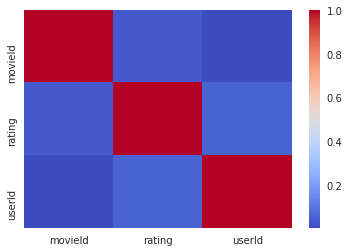

In [5]:
sns.heatmap(df.corr(), cmap='coolwarm')

In [6]:
import numpy as np
df['mealskew'] = df['movieId'].apply(lambda id: np.nan if id > 31 else id)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
movieId,1501.0,49.405730,28.937034,0.0,24.0,50.0,74.0,99.0
rating,1501.0,1.774151,1.187276,1.0,1.0,1.0,2.0,5.0
userId,1501.0,14.383744,8.591040,0.0,7.0,14.0,22.0,29.0
mealskew,486.0,15.502058,9.250634,0.0,7.0,15.0,23.0,31.0


In [8]:
mealmap = { 2. : "Chicken Curry",   
           3. : "Spicy Chicken Nuggest",   
           5. : "Hamburger",   
           9. : "Taco Surprise",  
           11. : "Meatloaf",  
           12. : "Ceaser Salad",  
           15. : "BBQ Ribs",  
           17. : "Sushi Plate",  
           19. : "Cheesesteak Sandwhich",  
           21. : "Lasagna",  
           23. : "Orange Chicken",
           26. : "Spicy Beef Plate",  
           27. : "Salmon with Mashed Potatoes",  
           28. : "Penne Tomatoe Pasta",  
           29. : "Pork Sliders",  
           30. : "Vietnamese Sandwich",  
           31. : "Chicken Wrap",  
           np.nan: "Cowboy Burger",   
           4. : "Pretzels and Cheese Plate",   
           6. : "Spicy Pork Sliders",  
           13. : "Mandarin Chicken PLate",  
           14. : "Kung Pao Chicken",
           16. : "Fried Rice Plate",  
           8. : "Chicken Chow Mein",  
           10. : "Roasted Eggplant ",  
           18. : "Pepperoni Pizza",  
           22. : "Pulled Pork Plate",   
           0. : "Cheese Pizza",   
           1. : "Burrito",   
           7. : "Nachos",  
           24. : "Chili",  
           20. : "Southwest Salad",  
           25.: "Roast Beef Sandwich"}

In [9]:
df['meal_name'] = df['mealskew'].map(mealmap)

In [10]:
df.head()

,movieId,rating,userId,mealskew,meal_name
0,2,3.0,0,2.0,Chicken Curry
1,3,1.0,0,3.0,Spicy Chicken Nuggest
2,5,2.0,0,5.0,Hamburger
3,9,4.0,0,9.0,Taco Surprise
4,11,1.0,0,11.0,Meatloaf


In [11]:
df.to_csv('Meal_Info.csv',index=False)

In [12]:
from pyspark.sql import SparkSession

In [13]:
spark = SparkSession.builder.appName('recconsulting').getOrCreate()

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [15]:
data = spark.read.csv('Meal_Info.csv',inferSchema=True,header=True)

In [16]:
data.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- mealskew: double (nullable = true)
 |-- meal_name: string (nullable = true)



In [17]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|           movieId|            rating|            userId|          mealskew|          meal_name|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|              1501|              1501|              1501|               486|                486|
|   mean| 49.40572951365756|1.7741505662891406|14.383744170552964|15.502057613168724|               null|
| stddev|28.937034065088994| 1.187276166124803| 8.591040424293272| 9.250633630277568|               null|
|    min|                 0|               1.0|                 0|               0.0|           BBQ Ribs|
|    max|                99|               5.0|                29|              31.0|Vietnamese Sandwich|
+-------+------------------+------------------+------------------+------------------+-------------------+



In [18]:
data.show()

+-------+------+------+--------+--------------------+
|movieId|rating|userId|mealskew|           meal_name|
+-------+------+------+--------+--------------------+
|      2|   3.0|     0|     2.0|       Chicken Curry|
|      3|   1.0|     0|     3.0|Spicy Chicken Nug...|
|      5|   2.0|     0|     5.0|           Hamburger|
|      9|   4.0|     0|     9.0|       Taco Surprise|
|     11|   1.0|     0|    11.0|            Meatloaf|
|     12|   2.0|     0|    12.0|        Ceaser Salad|
|     15|   1.0|     0|    15.0|            BBQ Ribs|
|     17|   1.0|     0|    17.0|         Sushi Plate|
|     19|   1.0|     0|    19.0|Cheesesteak Sandw...|
|     21|   1.0|     0|    21.0|             Lasagna|
|     23|   1.0|     0|    23.0|      Orange Chicken|
|     26|   3.0|     0|    26.0|    Spicy Beef Plate|
|     27|   1.0|     0|    27.0|Salmon with Mashe...|
|     28|   1.0|     0|    28.0| Penne Tomatoe Pasta|
|     29|   1.0|     0|    29.0|        Pork Sliders|
|     30|   1.0|     0|    3

In [19]:
data = data.na.drop(how='any')

In [20]:
(training, test) = data.randomSplit([0.8, 0.2])

In [21]:
# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="mealskew", ratingCol="rating")
model = als.fit(training)

In [22]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

predictions.show()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

+-------+------+------+--------+--------------------+-----------+
|movieId|rating|userId|mealskew|           meal_name| prediction|
+-------+------+------+--------+--------------------+-----------+
|     31|   1.0|     5|    31.0|        Chicken Wrap| -0.5719136|
|     31|   3.0|     8|    31.0|        Chicken Wrap| 0.71211636|
|     31|   3.0|     7|    31.0|        Chicken Wrap| -0.5008675|
|     31|   2.0|    25|    31.0|        Chicken Wrap|  0.5804788|
|     31|   3.0|    14|    31.0|        Chicken Wrap|  2.2254586|
|     31|   1.0|     0|    31.0|        Chicken Wrap|  0.3253705|
|     26|   1.0|     3|    26.0|    Spicy Beef Plate| 0.24666625|
|     26|   2.0|    25|    26.0|    Spicy Beef Plate| 0.09551735|
|     27|   1.0|    26|    27.0|Salmon with Mashe...|    4.06938|
|     27|   1.0|    21|    27.0|Salmon with Mashe...| -1.6575695|
|     12|   1.0|    16|    12.0|        Ceaser Salad| -0.3737074|
|     12|   1.0|    24|    12.0|        Ceaser Salad| 0.16464436|
|     22| 

In [33]:
# Single_user
single_user = test.filter(test['userId'] ==19).select(['movieId', 'userId', 'mealskew'])

In [34]:
single_user.show()

+-------+------+--------+
|movieId|userId|mealskew|
+-------+------+--------+
|      6|    19|     6.0|
|     11|    19|    11.0|
|     14|    19|    14.0|
+-------+------+--------+



In [35]:
recommendations = model.transform(single_user)

In [36]:
recommendations.orderBy('prediction', ascending=False).show()

+-------+------+--------+----------+
|movieId|userId|mealskew|prediction|
+-------+------+--------+----------+
|     11|    19|    11.0| 1.0406799|
|     14|    19|    14.0| 0.9727338|
|      6|    19|     6.0|0.61592305|
+-------+------+--------+----------+

